In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from prophet.diagnostics import cross_validation, performance_metrics
from suntime import Sun, SunTimeException
from datetime import timedelta
import ephem
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import r2_score

In [27]:
def create_lagged_features(df, column, lags):
    for lag in range(1, lags + 1):
        df[f'{column}_lag{lag}'] = df[column].shift(lag)
    return df

In [28]:
def get_data():
    file_path = '/Users/mubashirahmad/Library/CloudStorage/OneDrive-UniversityofHertfordshire/BDTI-Shared-Resources/Projects/On-Going/PowerBox/powerbox/powerbox/Data/processed_datasets/SI_SP_merged_filtered.csv'
    data = pd.read_csv(file_path)
    data['System Production (W)'] = data['System Production (W)'] / 1000
    n = len(data)
    train_size = int(n * 0.80)
    valid_size = int(n * 0.15)

    train_data = data.iloc[:train_size]
    valid_data = data.iloc[train_size:train_size + valid_size]
    test_data = data.iloc[train_size + valid_size:]
    print('Training Set: ',len(train_data),'Validation Set: ', len(valid_data),'Test Set: ', len(test_data))
    
    return train_data, valid_data, test_data

In [29]:
def data_init():
    train, valid, test = get_data()  # Assuming get_data() is your custom data loader function
    train = create_lagged_features(train, 'System Production (W)', 3)
    valid = create_lagged_features(valid, 'System Production (W)', 3)

    # Drop rows with NaN values created by lagging
    train = train.dropna().reset_index(drop=True)
    valid = valid.dropna().reset_index(drop=True)
    
    # Select relevant columns
    columns = [
        'Time', 'System Production (W)', 'System Production (W)_lag1',
        'System Production (W)_lag2', 'System Production (W)_lag3',
        'ALLSKY_SFC_SW_DWN', 'ALLSKY_SFC_UV_INDEX', 'T2MWET', 'ALLSKY_SFC_PAR_TOT',
        'ALLSKY_SRF_ALB', 'CLRSKY_SFC_SW_DWN', 'T2M', 'ALLSKY_KT',
        'CLRSKY_SFC_PAR_TOT', 'ALLSKY_SFC_SW_DIFF', 'ALLSKY_SFC_SW_DNI',
        'ALLSKY_SFC_UVB', 'ALLSKY_SFC_UVA'
    ]
    
    # Convert Time column to datetime and set as index
   
    train['Time'] = pd.to_datetime(train['Time'])
    train.set_index('Time', inplace=True)
    train.asfreq('h')
    
    valid['Time'] = pd.to_datetime(valid['Time'])
    valid.set_index('Time', inplace=True)
    valid.asfreq('h')
    
    # Exogenous features
    exog_columns = columns[2:]  # All columns except 'Time' and target variable

    # Scale the target variable
    scaler = RobustScaler()
    train['System Production (W)'] = scaler.fit_transform(train[['System Production (W)']])
    valid['System Production (W)'] = scaler.transform(valid[['System Production (W)']])

    # Scale the exogenous variables
    exog_scaler = RobustScaler()
    train_exog = exog_scaler.fit_transform(train[exog_columns])
    valid_exog = exog_scaler.transform(valid[exog_columns])

    return train, valid, train_exog, valid_exog, scaler, exog_scaler







In [30]:

def train_lightgbm(train, train_exog, valid, valid_exog):
    # Prepare the data for LightGBM
    train_target = train['System Production (W)'].values
    valid_target = valid['System Production (W)'].values
    
    # Create LightGBM dataset format
    train_data = lgb.Dataset(train_exog, label=train_target)
    valid_data = lgb.Dataset(valid_exog, label=valid_target, reference=train_data)

    # LightGBM parameters
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'seed': 42
    }

    # Train the model
    model = lgb.train(
        params, 
        train_data, 
        num_boost_round=1000, 
        valid_sets=[valid_data], 
        valid_names=['validation'],  # Name for validation set
        # early_stopping_rounds=50,  # Early stopping parameter
        # verbose_eval=100  # Display progress every 100 rounds
    )
    
   
    
    return model

# Initialize the data
train, valid, train_exog, valid_exog, scaler, exog_scaler = data_init()






Training Set:  15184 Validation Set:  2847 Test Set:  949


In [31]:
# Train the LightGBM model and get predictions
model = train_lightgbm(train, train_exog, valid, valid_exog)
predictions = model.predict(valid_exog, num_iteration=model.best_iteration)
# Inverse transform the predictions and validation target
predictions_inversed = scaler.inverse_transform(predictions.reshape(-1, 1))
valid_inversed = scaler.inverse_transform(valid[['System Production (W)']])

# Evaluate the model's performance
mae = mean_absolute_error(valid_inversed, predictions_inversed)
rmse = np.sqrt(mean_squared_error(valid_inversed, predictions_inversed))
r2 = r2_score(valid_inversed, predictions_inversed)
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R² Score: {r2}')
 


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3656
[LightGBM] [Info] Number of data points in the train set: 15181, number of used features: 16
[LightGBM] [Info] Start training from score 0.543278
Mean Absolute Error: 24.387808080988364
Root Mean Squared Error: 51.4607748300832
R² Score: 0.9112894730287713


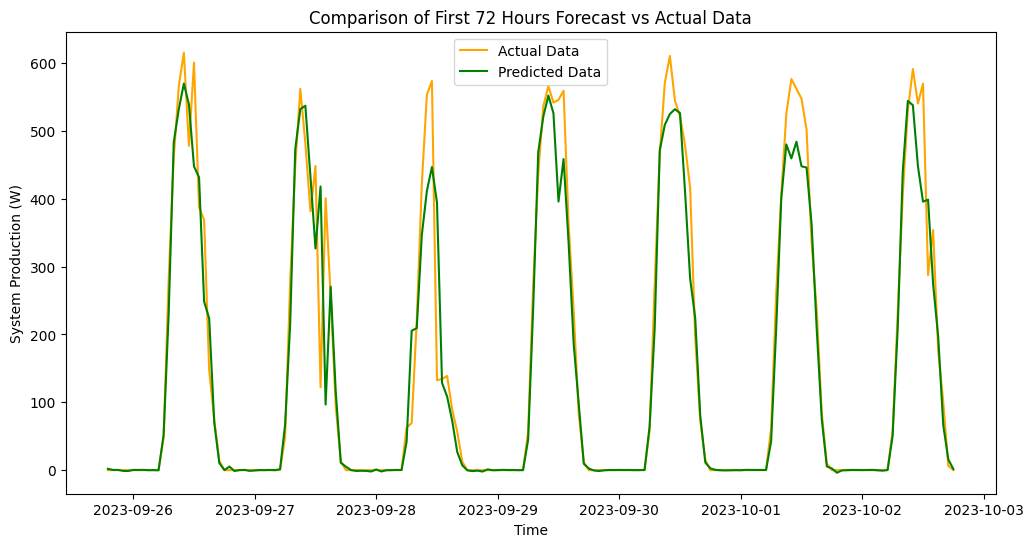

In [33]:
# Visualizing the predictions vs. actual values for the first 72 hours

# Select the first 72 hours for comparison
first_72_hours_valid = valid.iloc[:168]
first_72_hours_predictions = predictions_inversed[:168].flatten()

plt.figure(figsize=(12, 6))

# Plot the validation (actual) data
plt.plot(first_72_hours_valid.index, valid_inversed[:168], label='Actual Data', color='orange')

# Plot the forecasted data
plt.plot(first_72_hours_valid.index, first_72_hours_predictions, label='Predicted Data', color='green')

# Customize the plot
plt.title('Comparison of First 72 Hours Forecast vs Actual Data')
plt.xlabel('Time')
plt.ylabel('System Production (W)')
plt.legend()

plt.show()